# Cambio de enfoque y reejecución de tópicos
Para esta tercera entrega cambiamos el análisis de décadas a años porque con sólo 7 décadas no se podía modelar bien la serie temporal. Aquí repetimos el pipeline de la entrega 2 pero con granularidad anual.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import time
from collections import Counter, defaultdict

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaSeqModel

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

for resource in ("punkt", "stopwords"):
    nltk.download(resource, quiet=True)


In [2]:
raw_df = pd.read_csv("spanish_songs_wikidata.csv")

df = (
    raw_df
    .dropna(subset=["year", "lyrics"])
    .copy()
)

df["year"] = df["year"].astype(int)
df = df[(df["year"] >= 1940) & (df["year"] <= 2022)].copy()
df["views"] = df["views"].fillna(0)
df["decade"] = (df["year"] // 10) * 10

max_docs_per_decade = 2500
df_sorted = df.sort_values(["decade", "views"], ascending=[True, False])
df_reduced = (
    df_sorted.groupby("decade")
    .head(max_docs_per_decade)
    .reset_index(drop=True)
)

print(f"Reduced dataset shape: {df_reduced.shape}")
print(df_reduced.groupby("decade").size().sort_index())


Reduced dataset shape: (17082, 20)
decade
1940      32
1950     359
1960    1691
1970    2500
1980    2500
1990    2500
2000    2500
2010    2500
2020    2500
dtype: int64


In [3]:
spanish_stopwords = set(stopwords.words("spanish"))


def _load_spacy():
    global _nlp_es
    if "_nlp_es" in globals():
        return _nlp_es
    try:
        import spacy
    except ImportError as exc:
        raise ImportError(
            "spaCy es_core_news_sm is required. Install it via `python -m spacy download es_core_news_sm`."
        ) from exc
    try:
        _nlp_es = spacy.load("es_core_news_sm", disable=["parser", "ner"])
    except OSError as exc:
        raise OSError(
            "spaCy model es_core_news_sm not found. Install it via `python -m spacy download es_core_news_sm`."
        ) from exc
    return _nlp_es


def preprocess_text(text, min_len=3, remove_accents=True):
    if not isinstance(text, str):
        text = ""

    s = unicodedata.normalize("NFC", text)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"^\s*\[.*?(Letra|Lyrics).*?].*?(?:\n|$)", "", s, flags=re.IGNORECASE | re.MULTILINE)
    s = re.sub(r"^\s*(Letra|Lyrics).*?(?:\n|$)", "", s, flags=re.IGNORECASE | re.MULTILINE)
    s = re.sub(r"\[.*?\]", "", s)
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(
        r"^\s*(Coro|Verso|Intro|Outro|Bridge|Pre-Chorus|Post-Chorus|Hook|Interlude|Instrumental|Solo|Spoken|Ad-libs|Refrain|Chorus|Verse).*?:.*?(?:\n|$)",
        "",
        s,
        flags=re.IGNORECASE | re.MULTILINE,
    )

    lines = s.split("\n")[:80]
    s = "\n".join(lines)
    if len(s) > 1200:
        s = s[:1200]

    s = s.strip().lower()

    if remove_accents:
        normalized = unicodedata.normalize("NFKD", s)
        s = "".join(ch for ch in normalized if not unicodedata.combining(ch) or ch == "\u0303")
        s = s.replace("n\u0303", "ñ")

    s = re.sub(r"[^a-zñ\s]", " ", s)
    tokens = word_tokenize(s, language="spanish") if s else []
    tokens = [t for t in tokens if len(t) >= min_len]
    tokens = [t for t in tokens if not (re.fullmatch(r"[aeiouh]+", t) and len(t) >= 3)]
    tokens = [t for t in tokens if t not in spanish_stopwords]
    if not tokens:
        return []

    nlp = _load_spacy()
    doc = nlp(" ".join(tokens))
    lemmas = []
    for tok in doc:
        lemma = tok.lemma_.lower().strip()
        if len(lemma) < min_len:
            continue
        if lemma in spanish_stopwords:
            continue
        lemmas.append(lemma)
    return lemmas


In [5]:
start = time.time()

cache_dir = Path(".")
dict_path = Path("diccionario_ldaseq.dict")
corpus_path = Path("corpus_ladaseq.mm")

df_reduced["lyrics"] = df_reduced["lyrics"].fillna("")
df_reduced["processed_text"] = df_reduced["lyrics"].apply(preprocess_text)

df_reduced = df_reduced[df_reduced["processed_text"].map(bool)].copy()
df_reduced = df_reduced.sort_values(["year", "views"], ascending=[True, False]).reset_index(drop=True)

if dict_path.exists() and corpus_path.exists():
    print("Loading cached dictionary and corpus...")
    dictionary = corpora.Dictionary.load(str(dict_path))
    corpus = list(corpora.MmCorpus(str(corpus_path)))
else:
    print("Building dictionary and corpus from scratch...")
    dictionary = Dictionary(df_reduced["processed_text"])
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in df_reduced["processed_text"]]
    dictionary.save(str(dict_path))
    corpora.MmCorpus.serialize(str(corpus_path), corpus)
    print("Dictionary and corpus saved to disk.")

elapsed = time.time() - start
print(f"Corpus prepared in {elapsed:.1f}s")
print(f"Vocabulary size: {len(dictionary)}")
print(f"Documents in corpus: {len(corpus)}")
print(
    f"Years covered: {df_reduced['year'].min()} - {df_reduced['year'].max()} "
    f"({df_reduced['year'].nunique()} periods)"
)


Loading cached dictionary and corpus...
Corpus prepared in 110.8s
Vocabulary size: 16313
Documents in corpus: 17082
Years covered: 1940 - 2022 (81 periods)
Corpus prepared in 110.8s
Vocabulary size: 16313
Documents in corpus: 17082
Years covered: 1940 - 2022 (81 periods)


In [6]:
year_counts = df_reduced.groupby("year").size().sort_index()
time_slices = year_counts.tolist()
year_labels = year_counts.index.tolist()

print(f"Total documents after preprocessing: {len(df_reduced)}")
print(f"Number of yearly time slices: {len(time_slices)}")
print(year_counts.head())
assert sum(time_slices) == len(corpus), "Corpus size does not match time slices"


Total documents after preprocessing: 17082
Number of yearly time slices: 81
year
1940    10
1941     1
1943     8
1944     4
1945     3
dtype: int64


In [7]:
num_topics = 7
chain_variance = 0.10
passes = 10

model_path = Path("modelo_ldaseq.model")

if model_path.exists():
    print("Loading cached LdaSeqModel...")
    ldaseq_model = LdaSeqModel.load(str(model_path))
    if ldaseq_model.num_topics != num_topics:
        print(
            f"Warning: cached model has {ldaseq_model.num_topics} topics, expected {num_topics}."
        )
else:
    print("Training new LdaSeqModel (this may take a while)...")
    ldaseq_model = LdaSeqModel(
        corpus=corpus,
        time_slice=time_slices,
        num_topics=num_topics,
        id2word=dictionary,
        chain_variance=chain_variance,
        passes=passes,
    )
    ldaseq_model.save(str(model_path))
    print("LdaSeqModel trained and cached.")

model_time_slices = getattr(ldaseq_model, "time_slice", None)
if model_time_slices is not None:
    if sum(model_time_slices) != len(corpus):
        raise ValueError(
            "Loaded model corpus size mismatch. Rebuild dictionary/corpus or retrain the model."
        )

print("LdaSeqModel ready with yearly slices.")


Loading cached LdaSeqModel...
LdaSeqModel ready with yearly slices.
LdaSeqModel ready with yearly slices.


In [8]:
ldaseq_model.save("modelo_ldaseq.model")

In [8]:
print(f"Dictionary cached at: {dict_path.resolve()}")
print(f"Corpus cached at: {corpus_path.resolve()}")

Dictionary cached at: C:\Users\nacho\Desktop\Universidad\Cuarto\DCDC\Practica\3_mineria_de_datos_complejos\diccionario_ldaseq.dict
Corpus cached at: C:\Users\nacho\Desktop\Universidad\Cuarto\DCDC\Practica\3_mineria_de_datos_complejos\corpus_ladaseq.mm


In [16]:
def _extract_topic_terms(model, topic_id, time_idx, topn=10):
    """Return list of (term, weight) using show_topic/print_topic fallbacks."""

    def _parse_string_topic(topic_str):
        parsed = []
        for chunk in topic_str.split(" + "):
            if "*" not in chunk:
                continue
            weight_str, term_str = chunk.split("*", 1)
            try:
                weight = float(weight_str)
            except ValueError:
                continue
            term = term_str.strip().strip('"')
            parsed.append((term, weight))
        return parsed

    def _parse_sequence_topic(seq):
        parsed = []
        for item in seq:
            if isinstance(item, str):
                parsed.extend(_parse_string_topic(item))
                continue
            if not isinstance(item, (list, tuple)) or len(item) < 2:
                continue
            first, second = item[0], item[1]
            if isinstance(first, str) and isinstance(second, (int, float)):
                term, weight = first, second
            elif isinstance(second, str) and isinstance(first, (int, float)):
                term, weight = second, first
            else:
                continue
            try:
                parsed.append((term, float(weight)))
            except (TypeError, ValueError):
                continue
        return parsed

    if hasattr(model, "show_topic"):
        try:
            topic_data = model.show_topic(topicid=topic_id, time=time_idx, topn=topn)
        except TypeError:
            topic_data = model.show_topic(topic_id, time_idx)
        except Exception:
            topic_data = None
        if isinstance(topic_data, (list, tuple)):
            pairs = _parse_sequence_topic(topic_data)
            if pairs:
                return pairs

    topic_repr = model.print_topic(topic=topic_id, time=time_idx, top_terms=topn)
    if isinstance(topic_repr, str):
        return _parse_string_topic(topic_repr)
    if isinstance(topic_repr, (list, tuple)):
        pairs = _parse_sequence_topic(topic_repr)
        if pairs:
            return pairs
    return []


def print_topic_evolution(model, years, topn=10, sample_step=5):
    for idx, year in enumerate(years):
        if sample_step and idx % sample_step != 0 and idx not in (0, len(years) - 1):
            continue
        print(f"\nYear {year}")
        for topic_id in range(model.num_topics):
            terms = _extract_topic_terms(model, topic_id, idx, topn=topn)
            readable = ", ".join(f"{term}:{weight:.3f}" for term, weight in terms)
            print(f"Topic {topic_id}: {readable}")


print_topic_evolution(ldaseq_model, year_labels, topn=8, sample_step=10)


Year 1940
Topic 0: guantanamera:0.058, cantar:0.039, guajira:0.033, querer:0.018, amor:0.015, tierra:0.013, hombre:0.012, decir:0.011
Topic 1: madre:0.135, niño:0.101, niña:0.039, llorar:0.033, duermete:0.022, adorar:0.021, burlar:0.020, muero:0.019
Topic 2: bailar:0.111, fiesta:0.096, quebrado:0.073, charango:0.071, humahuaqueño:0.071, bombo:0.071, carnaval:0.058, llegar:0.027
Topic 3: adio:0.067, bello:0.054, ser:0.030, poder:0.028, besame:0.024, amor:0.023, querer:0.019, vez:0.018
Topic 4: mas:0.025, niño:0.022, dormir:0.017, cosa:0.011, viento:0.010, pecho:0.010, querer:0.009, cielo:0.008
Topic 5: ahora:0.103, asi:0.064, pasar:0.031, decir:0.021, mujer:0.019, gozar:0.014, importa:0.013, gusto:0.012
Topic 6: decir:0.029, mama:0.023, hacer:0.023, bailar:0.015, hombre:0.015, querer:0.013, venir:0.012, alegre:0.011

Year 1952
Topic 0: querer:0.016, flor:0.014, traigo:0.012, cantar:0.011, decir:0.010, pedir:0.008, virgen:0.008, hombre:0.007
Topic 1: niño:0.098, adorar:0.045, belir:0.01

In [18]:
doc_bounds = []
start_idx = 0
for count in time_slices:
    doc_bounds.append((start_idx, start_idx + count))
    start_idx += count

topic_term_history = {}
doc_topic_records = []

for time_idx, (year, (start, end)) in enumerate(zip(year_labels, doc_bounds)):
    dtm_vis_output = ldaseq_model.dtm_vis(corpus=corpus, time=time_idx)
    if len(dtm_vis_output) < 2:
        raise ValueError("dtm_vis output does not contain the expected topic arrays")
    vis_doc_topics = np.asarray(dtm_vis_output[0])
    vis_topic_terms = np.asarray(dtm_vis_output[1])
    period_doc_topics = vis_doc_topics[start:end]
    if len(period_doc_topics) != (end - start):
        raise ValueError(
            f"Doc-topic slice mismatch for year {year}: "
            f"expected {end - start}, got {len(period_doc_topics)}"
        )

    topic_term_history[year] = vis_topic_terms
    period_meta = df_reduced.iloc[start:end].reset_index(drop=True)

    for row_offset, topic_probs in enumerate(period_doc_topics):
        meta_row = period_meta.iloc[row_offset]
        record = {
            "doc_index": start + row_offset,
            "year": int(year),
            "decade": int(meta_row["decade"]),
            "title": meta_row.get("title"),
            "artist": meta_row.get("artist"),
        }
        for topic_id, prob in enumerate(topic_probs):
            record[f"topic_{topic_id}"] = float(prob)
        doc_topic_records.append(record)

doc_topic_df = pd.DataFrame(doc_topic_records)
topic_cols = [col for col in doc_topic_df.columns if col.startswith("topic_")]
topic_value_counts = doc_topic_df.groupby("year")[topic_cols].mean().reset_index()

display(doc_topic_df.head())
display(topic_value_counts.head())

,doc_index,year,decade,title,artist,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0,1940,1940,Guajira Guantanamera,Compay Segundo,0.966848,0.000099,0.000099,0.000099,0.000099,0.032657,0.000099
1,1,1940,1940,Cartucho. El General Rueda,Nellie Campobello,0.000105,0.048006,0.000105,0.000105,0.000105,0.000105,0.951468
2,2,1940,1940,Bésame Mucho,Consuelo Velzquez,0.000294,0.000294,0.000294,0.998239,0.000294,0.000294,0.000294
3,3,1940,1940,El Rancho Grande Give Me My Ranch,Gene Autry,0.000270,0.000270,0.531049,0.000270,0.000270,0.000270,0.467602
4,4,1940,1940,Después que te conocí,Eduard Toldr,0.000243,0.000243,0.000243,0.602188,0.396594,0.000243,0.000243


,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,1940,0.222656,0.097556,0.053309,0.240720,0.145274,0.074025,0.166459
1,1941,0.125198,0.000156,0.874022,0.000156,0.000156,0.000156,0.000156
2,1943,0.049016,0.037078,0.010511,0.121684,0.754929,0.000334,0.026449
3,1944,0.268809,0.003856,0.000159,0.146457,0.288921,0.000159,0.291639
4,1945,0.397427,0.000139,0.014629,0.268939,0.000139,0.000139,0.318588


In [19]:
topic_term_rows = []
for time_idx, year in enumerate(year_labels):
    for topic_id in range(num_topics):
        terms = _extract_topic_terms(ldaseq_model, topic_id, time_idx, topn=10)
        for rank, (term, weight) in enumerate(terms, start=1):
            topic_term_rows.append(
                {
                    "year": int(year),
                    "topic": topic_id,
                    "rank": rank,
                    "term": term,
                    "weight": float(weight),
                }
            )

topic_term_evolution_df = pd.DataFrame(topic_term_rows)
display(topic_term_evolution_df.head(20))


,year,topic,rank,term,weight
0,1940,0,1,guantanamera,0.057507
1,1940,0,2,cantar,0.039226
2,1940,0,3,guajira,0.033163
3,1940,0,4,querer,0.018173
4,1940,0,5,amor,0.014984
5,1940,0,6,tierra,0.012693
6,1940,0,7,hombre,0.011771
7,1940,0,8,decir,0.010543
8,1940,0,9,guantanamero,0.010434
9,1940,0,10,rosa,0.008569


In [ ]:
def show_topic_terms(topic_id, year=None, topn=10):
    subset = topic_term_evolution_df[topic_term_evolution_df["topic"] == topic_id]
    if year is not None:
        subset = subset[subset["year"] == year]
    subset = subset.sort_values(["year", "rank"]).groupby("year").head(topn)
    return subset.reset_index(drop=True)

all_topics_glimpse = (
    topic_term_evolution_df[topic_term_evolution_df["rank"] <= 5]
    .groupby(["topic", "term"])["weight"]
    .mean()
    .reset_index()
    .sort_values(["topic", "weight"], ascending=[True, False])
)

display(all_topics_glimpse)


,topic,term,weight
25,0,guantanamera,0.037245
24,0,guajira,0.023202
18,0,dios,0.017398
15,0,dame,0.017112
5,0,bueno,0.016882
36,0,maria,0.016880
6,0,camino,0.016348
39,0,mezclado,0.016284
20,0,flores,0.016144
55,0,ser,0.015780


In [20]:
topic_shift_rows = []
for idx in range(1, len(year_labels)):
    prev_year = year_labels[idx - 1]
    curr_year = year_labels[idx]
    prev_matrix = topic_term_history[prev_year]
    curr_matrix = topic_term_history[curr_year]

    for topic_id in range(num_topics):
        prev_vec = np.asarray(prev_matrix[topic_id])
        curr_vec = np.asarray(curr_matrix[topic_id])
        denom = (np.linalg.norm(prev_vec) * np.linalg.norm(curr_vec)) + 1e-12
        similarity = float(np.dot(prev_vec, curr_vec) / denom)
        topic_shift_rows.append(
            {
                "previous_year": int(prev_year),
                "year": int(curr_year),
                "topic": topic_id,
                "similarity": similarity,
                "shift_score": 1.0 - similarity,
            }
        )

topic_shift_df = pd.DataFrame(topic_shift_rows)
display(topic_shift_df.sort_values("shift_score", ascending=False).head(20))


,previous_year,year,topic,similarity,shift_score
120,1959,1960,1,0.619735,0.380265
240,1976,1977,2,0.769333,0.230667
139,1961,1962,6,0.783650,0.216350
180,1967,1968,5,0.791064,0.208936
492,2012,2013,2,0.799245,0.200755
338,1990,1991,2,0.808749,0.191251
121,1959,1960,2,0.808888,0.191112
254,1978,1979,2,0.819335,0.180665
331,1989,1990,2,0.821588,0.178412
275,1981,1982,2,0.823473,0.176527


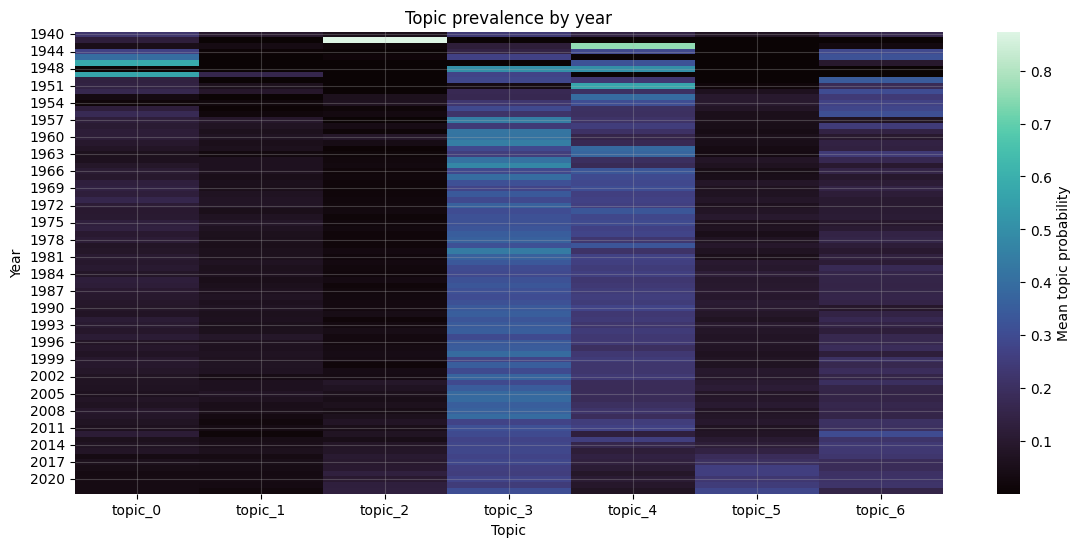

In [21]:
topic_over_time = (
    doc_topic_df.groupby("year")[topic_cols]
    .mean()
    .sort_index()
)

plt.figure(figsize=(14, 6))
sns.heatmap(topic_over_time, cmap="mako", cbar_kws={"label": "Mean topic probability"})
plt.title("Topic prevalence by year")
plt.xlabel("Topic")
plt.ylabel("Year")
plt.show()


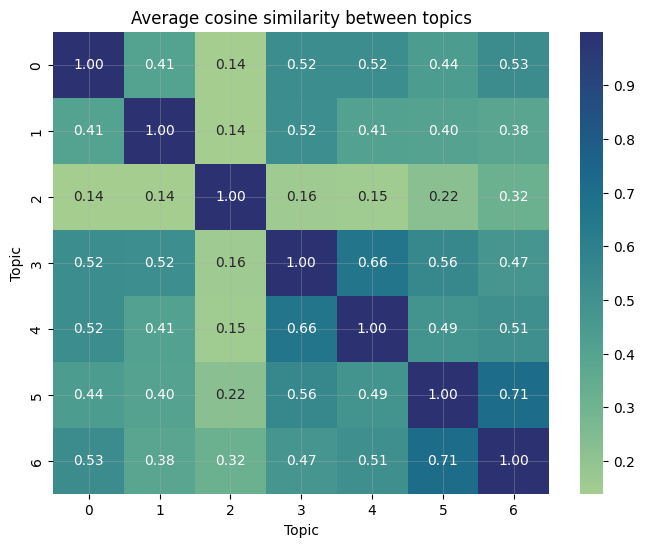

In [22]:
topic_term_stack = np.stack([topic_term_history[year] for year in year_labels], axis=0)
mean_topic_term = topic_term_stack.mean(axis=0)

similarity_matrix = np.zeros((num_topics, num_topics))
for i in range(num_topics):
    for j in range(num_topics):
        denom = (np.linalg.norm(mean_topic_term[i]) * np.linalg.norm(mean_topic_term[j])) + 1e-12
        similarity_matrix[i, j] = float(np.dot(mean_topic_term[i], mean_topic_term[j]) / denom)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="crest")
plt.title("Average cosine similarity between topics")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


In [23]:
year_token_counts = defaultdict(Counter)
for _, row in df_reduced.dropna(subset=["processed_text"]).iterrows():
    tokens = row["processed_text"]
    if not isinstance(tokens, (list, tuple)):
        continue
    filtered_tokens = [tok for tok in tokens if len(tok) > 3]
    if not filtered_tokens:
        continue
    year_token_counts[row["year"]].update(filtered_tokens)

year_term_freq = {}
for year, token_counter in year_token_counts.items():
    total = sum(token_counter.values())
    if total == 0:
        continue
    year_term_freq[year] = {
        term: count / total for term, count in token_counter.items() if count >= 5
    }

years_sorted = sorted(year_term_freq)
spike_records = []
for idx in range(1, len(years_sorted)):
    prev_year = years_sorted[idx - 1]
    curr_year = years_sorted[idx]
    prev_freqs = year_term_freq.get(prev_year, {})
    curr_freqs = year_term_freq.get(curr_year, {})
    for term, freq in curr_freqs.items():
        delta = freq - prev_freqs.get(term, 0)
        if delta <= 0:
            continue
        spike_records.append(
            {
                "year": curr_year,
                "previous_year": prev_year,
                "term": term,
                "frequency_delta": delta,
                "current_freq": freq,
                "previous_freq": prev_freqs.get(term, 0),
            }
        )

if spike_records:
    spike_df = (
        pd.DataFrame(spike_records)
        .sort_values(["year", "frequency_delta"], ascending=[True, False])
        .reset_index(drop=True)
    )
    top_keyword_spikes = spike_df.groupby("year").head(10).reset_index(drop=True)
    display(top_keyword_spikes.head(40))
else:
    print("No sudden keyword spikes detected.")


,year,previous_year,term,frequency_delta,current_freq,previous_freq
0,1941,1940,quebradeño,0.083333,0.083333,0.0
1,1941,1940,fiesta,0.083333,0.083333,0.0
2,1941,1940,quebrado,0.083333,0.083333,0.0
3,1941,1940,humahuaqueño,0.083333,0.083333,0.0
4,1941,1940,cantar,0.083333,0.083333,0.0
5,1941,1940,erke,0.083333,0.083333,0.0
6,1941,1940,charango,0.083333,0.083333,0.0
7,1941,1940,bombo,0.083333,0.083333,0.0
8,1941,1940,carnavalito,0.083333,0.083333,0.0
9,1941,1940,bailar,0.083333,0.083333,0.0


In [24]:
from pysentimiento import create_analyzer

sentiment_analyzer = create_analyzer(task="sentiment", lang="es")

sentiment_mapping = {"POS": 1, "NEU": 0, "NEG": -1}
sentiment_cols = ["sentiment_label", "prob_pos", "prob_neg", "prob_neu"]

batch_size = 128
texts = df_reduced["lyrics"].tolist()
results = []
for i in range(0, len(texts), batch_size):
    batch = texts[i : i + batch_size]
    batch_results = sentiment_analyzer.predict(batch)
    for r in batch_results:
        results.append((r.output, r.probas["POS"], r.probas["NEG"], r.probas["NEU"]))

df_reduced[sentiment_cols] = pd.DataFrame(results, index=df_reduced.index)
df_reduced["sentiment_polarity"] = df_reduced["sentiment_label"].map(sentiment_mapping)

sentiment_by_year = (
    df_reduced.groupby("year")
    .agg(
        mean_polarity=("sentiment_polarity", "mean"),
        share_positive=("sentiment_label", lambda x: (x == "POS").mean()),
        share_negative=("sentiment_label", lambda x: (x == "NEG").mean()),
        share_neutral=("sentiment_label", lambda x: (x == "NEU").mean()),
    )
    .reset_index()
)

display(sentiment_by_year.head())


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

C:\Users\nacho\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

,year,mean_polarity,share_positive,share_negative,share_neutral
0,1940,0.300000,0.400000,0.100,0.500000
1,1941,0.000000,0.000000,0.000,1.000000
2,1943,0.000000,0.125000,0.125,0.750000
3,1944,-1.000000,0.000000,1.000,0.000000
4,1945,0.666667,0.666667,0.000,0.333333


In [25]:
doc_topic_df = doc_topic_df.merge(
    df_reduced.reset_index().rename(columns={"index": "doc_index"})[
        ["doc_index", "sentiment_polarity", "sentiment_label"]
    ],
    on="doc_index",
    how="left",
)


In [26]:
sentiment_by_topic_rows = []
for topic_col in topic_cols:
    topic_id = int(topic_col.split("_")[1])
    weights = doc_topic_df[topic_col]
    sentiments = doc_topic_df["sentiment_polarity"].fillna(0)
    total_weight = weights.sum()
    if total_weight == 0:
        continue
    weighted_sentiment = (weights * sentiments).sum() / total_weight
    weighted_positive = (
        weights * (doc_topic_df["sentiment_label"] == "POS").astype(float)
    ).sum() / total_weight
    weighted_negative = (
        weights * (doc_topic_df["sentiment_label"] == "NEG").astype(float)
    ).sum() / total_weight
    sentiment_by_topic_rows.append(
        {
            "topic": topic_id,
            "mean_polarity": weighted_sentiment,
            "share_positive": weighted_positive,
            "share_negative": weighted_negative,
        }
    )

sentiment_by_topic = pd.DataFrame(sentiment_by_topic_rows)
display(sentiment_by_topic)


,topic,mean_polarity,share_positive,share_negative
0,0,-0.060443,0.274643,0.335085
1,1,-0.331219,0.151633,0.482852
2,2,0.000639,0.131029,0.130390
3,3,-0.215082,0.186819,0.401902
4,4,-0.142294,0.183229,0.325524
5,5,-0.145374,0.100853,0.246227
6,6,-0.220532,0.111329,0.331861


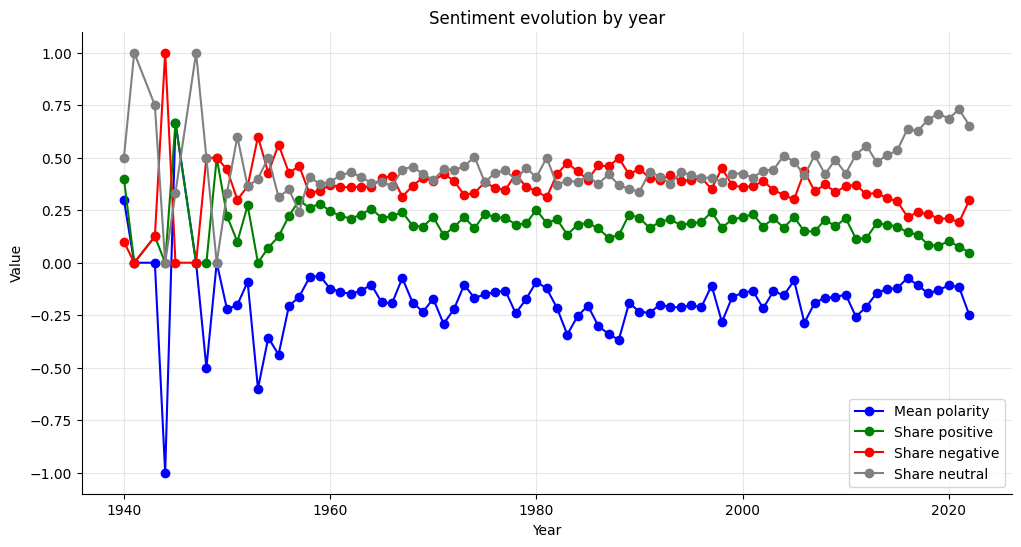

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(
    sentiment_by_year["year"],
    sentiment_by_year["mean_polarity"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Mean polarity",
)
plt.plot(
    sentiment_by_year["year"],
    sentiment_by_year["share_positive"],
    marker="o",
    linestyle="-",
    color="green",
    label="Share positive",
)
plt.plot(
    sentiment_by_year["year"],
    sentiment_by_year["share_negative"],
    marker="o",
    linestyle="-",
    color="red",
    label="Share negative",
)
plt.plot(
    sentiment_by_year["year"],
    sentiment_by_year["share_neutral"],
    marker="o",
    linestyle="-",
    color="gray",
    label="Share neutral",
)
plt.title("Sentiment evolution by year")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [28]:
topic_term_evolution_df.to_csv("topics_all_year.csv", index=False)
doc_topic_df.to_csv("doc_topic_year.csv", index=False)
sentiment_by_year.to_csv("sentiment_by_year.csv", index=False)
print("Exported topics_all_year.csv, doc_topic_year.csv, and sentiment_by_year.csv")


Exported topics_all_year.csv, doc_topic_year.csv, and sentiment_by_year.csv


In [29]:
df_topics = doc_topic_df.set_index("doc_index")[topic_cols]
final_dataset = df_reduced.join(df_topics, how="left")
final_dataset.to_csv("dataset_entrega3_final.csv", index=False)
print(f"Final dataset saved with shape {final_dataset.shape}")


Final dataset saved with shape (17082, 33)
